In [ ]:
import os
import numpy as np
from scipy.io import wavfile
from scipy.signal import butter, filtfilt
import soundfile as sf
import librosa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/Speech-breath_data/speech-breath.zip -d /content/dataset

Archive:  /content/drive/MyDrive/Speech-breath_data/speech-breath.zip
   creating: /content/dataset/Breath Train/
  inflating: /content/dataset/Breath Train/speaker12_channel3_trial1.wav  
  inflating: /content/dataset/Breath Train/speaker12_channel3_trial10.wav  
  inflating: /content/dataset/Breath Train/speaker12_channel3_trial2.wav  
  inflating: /content/dataset/Breath Train/speaker15_channel3_trial1.wav  
  inflating: /content/dataset/Breath Train/speaker15_channel3_trial10.wav  
  inflating: /content/dataset/Breath Train/speaker15_channel3_trial2.wav  
  inflating: /content/dataset/Breath Train/speaker2_channel3_trial1.wav  
  inflating: /content/dataset/Breath Train/speaker2_channel3_trial10.wav  
  inflating: /content/dataset/Breath Train/speaker2_channel3_trial2.wav  
  inflating: /content/dataset/Breath Train/speaker36_channel3_trial1.wav  
  inflating: /content/dataset/Breath Train/speaker36_channel3_trial10.wav  
  inflating: /content/dataset/Breath Train/speaker36_channel

In [ ]:
class Preprocess():
    def __init__(self, speech_folder, breath_folder, output_folder):
        self.speech_folder = speech_folder
        self.breath_folder = breath_folder
        self.output_folder = output_folder


    def low_pass_filter(self, data, fs, cutoff_freq=200, order=4):
        nyquist = 0.5 * fs  # Nyquist frequency is half of the sampling rate
        normal_cutoff = cutoff_freq / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        filtered_data = filtfilt(b, a, data)
        return filtered_data

    def downsample(self, audio_data, sr, target_sr=500):
        return librosa.resample(audio_data, orig_sr=sr, target_sr=target_sr)

    def segment_audio(self, audio_data, sr, target_duration, min_pad_duration):
        num_samples = len(audio_data)
        segment_samples = target_duration * sr
        min_pad_samples = min_pad_duration * sr
        num_segments = num_samples // segment_samples
        remainder_segments = num_samples % segment_samples

        x_train = []

        for i in range(num_segments):
            segment_data = audio_data[i * segment_samples : (i + 1) * segment_samples]
            x_train.append(segment_data)
            # print(f'Saved segment {i+1} of Shape = {segment_data.shape} Total shape = ({len(x_train)}, {len(x_train[0])})')

        if remainder_segments > 0:
            remainder_data = audio_data[num_segments * segment_samples:]

            # If the remaining audio is longer than 20 seconds but less than 34, pad with zeros
            if remainder_segments >= min_pad_samples:
                if remainder_segments < segment_samples:
                    remainder_data = np.pad(remainder_data, (0, segment_samples - remainder_segments), mode='constant')

                x_train.append(remainder_data)
                # print(f'Saved remaining segment Shape = {remainder_data.shape}')

        return x_train

    def save_preprocessed(self):
      for i,dir in enumerate([self.speech_folder, self.breath_folder]):
        final_stack=[]
        for filename in sorted(os.listdir(dir)):
          if filename.endswith('.wav'):
            input_file_path = os.path.join(dir, filename)
            audio_data, sr = librosa.load(input_file_path)
            if i==0:
              low_pass = self.low_pass_filter(audio_data, sr)
              target_sr = 500
              audio_data = low_pass
            down_pass = self.downsample(audio_data, sr, target_sr)
            target_duration = 4
            pad_duration = 3
            audio_stack = self.segment_audio(down_pass, target_sr, target_duration, pad_duration)
            final_stack.extend(audio_stack)

        final_data = np.array(final_stack)
        save_path = f"/content/drive/MyDrive/Preprocessed_files/{target_duration}s{pad_duration}p"
        if not os.path.exists(save_path):
          os.mkdir(save_path)

        if i==0:
          final_data = np.expand_dims(final_data, axis=1)
        np.save(f"{save_path}/{dir.split('/')[-1].split()[0]}.npy", final_data)

        print(f"Total number of audio files processed for {dir.split('/')[-1]}: ({len(final_stack)}, {len(final_stack[0])}) Numpy : {final_data.shape}")

In [ ]:
pp = Preprocess("/content/dataset/Speech Train", "/content/dataset/Breath Train", "/content")
# print(sorted(os.listdir("/content/dataset/Speech Train")))
# print('----------------------\n')
# print(sorted(os.listdir("/content/dataset/Breath Train")))

pp.save_preprocessed()

Total number of audio files processed for Speech Train: (397, 2000) Numpy : (397, 1, 2000)
Total number of audio files processed for Breath Train: (397, 2000) Numpy : (397, 2000)


In [ ]:
from tensorflow.keras import layers, models

# Define the Model
model = models.Sequential([
    layers.Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(2000, 1)),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),

    layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(pool_size=2),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')  # Adjust activation as needed
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print Model Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1996, 32)            │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 998, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 994, 64)             │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 497, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 493, 128)            │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 246, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 31488)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,015,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,066,945 (7.88 MB)

 Trainable params: 2,066,945 (7.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define a more compact CNN model
model = models.Sequential()

# First Conv1D layer
model.add(layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(2000, 1)))
model.add(layers.MaxPooling1D(pool_size=2))

# Second Conv1D layer
model.add(layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))

# Third Conv1D layer
model.add(layers.Conv1D(filters=128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))

# Fourth Conv1D layer
model.add(layers.Conv1D(filters=256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))

# Use Global Average Pooling instead of Flatten
model.add(layers.GlobalAveragePooling1D())

# Fully connected (dense) layer
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout for regularization

# Output layer (shape = 10000)
model.add(layers.Dense(10000))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Summary of the modified model architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 2000, 32)            │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 1000, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 1000, 64)            │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 500, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 500, 128)            │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 250, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 250, 256)            │         164,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 125, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10000)               │       2,570,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,851,472 (10.88 MB)

 Trainable params: 2,851,472 (10.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import numpy as np
import tensorflow as tf

# Load Data
speech_dataset_path = '/content/drive/MyDrive/Preprocessed_files/4s3p'
x_train = np.load(f"{speech_dataset_path}/Speech.npy")
y_train = np.load(f"{speech_dataset_path}/Breath.npy")

# Remove the extra dimension for Conv1D
x_train = np.squeeze(x_train, axis=1)  # Shape becomes (802, 1000)
y_train = np.expand_dims(y_train, axis=-1)  # Ensure proper output shape

# Create TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(64).shuffle(buffer_size=2000)


In [ ]:
# Reshape x_train and y_train to match the input/output format
##x_train = x_train.reshape((341, 2000, 1))  # Add the last dimension for 1D input
#y_train = y_train.reshape((341, 2000))     # No need for an additional dimension here

# Train the model
history = model.fit(x_train, y_train, epochs=200, batch_size=8, validation_split=0.2)

Epoch 1/200


ValueError: Dimensions must be equal, but are 2000 and 10000 for '{{node compile_loss/mean_squared_error/sub}} = Sub[T=DT_FLOAT](compile_loss/mean_squared_error/Squeeze, sequential_1_1/dense_3_1/BiasAdd)' with input shapes: [?,2000], [?,10000].

In [ ]:
model.fit(
    train_dataset,
    epochs=1000,
    verbose=1
)


Epoch 1/1000


ValueError: Dimensions must be equal, but are 2000 and 10000 for '{{node compile_loss/mean_squared_error/sub}} = Sub[T=DT_FLOAT](compile_loss/mean_squared_error/Squeeze, sequential_1_1/dense_3_1/BiasAdd)' with input shapes: [?,2000], [?,10000].

In [ ]:
model.save("my_model.keras")


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

In [ ]:
# Prediction
pp = Preprocess("","","")
audio_data, sr = librosa.load("/content/speaker53_channel1_trial1.wav")
low_pass = pp.low_pass_filter(audio_data, sr)
downsampled = pp.downsample(low_pass, sr, target_sr=500)
segmented_audio = pp.segment_audio(downsampled, 500, target_duration=2, min_pad_duration=1)
input_tensor = np.expand_dims(np.array(segmented_audio), axis=-1)
predicted_breath = model.predict(input_tensor)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


In [ ]:
# Trim to match length
min_length = min(len(predicted_breath), len(breath_data))
predicted_breath = predicted_breath[:min_length]
breath_data = breath_data[:min_length]

Correlation: 0.5654
MSE: 0.0191


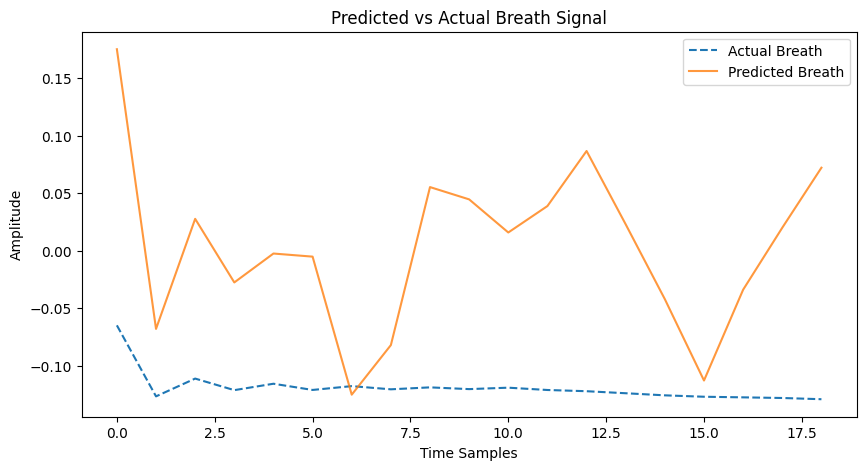

In [ ]:
# Load actual breath data
breath_data, sr = librosa.load("/content/speaker53_channel2_trial1.wav")
downsampled = pp.downsample(breath_data, sr, target_sr=500)
segmented_audio = pp.segment_audio(downsampled, 500, target_duration=2, min_pad_duration=1)
breath_data = np.concatenate(segmented_audio)

# Calculate Metrics
correlation = np.corrcoef(breath_data[:len(predicted_breath)], predicted_breath[:, 0])[0, 1]
mse = mean_squared_error(breath_data[:len(predicted_breath)], predicted_breath[:, 0])
print(f"Correlation: {correlation:.4f}")
print(f"MSE: {mse:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(breath_data[:len(predicted_breath)], label='Actual Breath', linestyle='dashed')
plt.plot(predicted_breath[:, 0], label='Predicted Breath', alpha=0.8)
plt.xlabel("Time Samples")
plt.ylabel("Amplitude")
plt.title("Predicted vs Actual Breath Signal")
plt.legend()
plt.show()

In [ ]:
# Preprocess input audio
pp = Preprocess("","","")
input_audio, sr = librosa.load("/content/speaker53_channel1_trial1.wav", sr=None)
low_pass_audio = pp.low_pass_filter(input_audio, sr)
downsampled_audio = pp.downsample(low_pass_audio, sr, target_sr=500)
segmented_audio = pp.segment_audio(downsampled_audio, sr=500,target_duration=2,min_pad_duration=1)

In [ ]:
# Ensure correct input shape
input_tensor = np.expand_dims(segmented_audio, axis=-1)  # Shape: (num_segments, 1000, 1)

In [ ]:
# Predict
predicted_breath = model.predict(input_tensor)
predicted_breath = predicted_breath.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [ ]:
# Load actual breath data
actual_breath, sr = librosa.load("/content/speaker53_channel2_trial1.wav", sr=None)
downsampled_breath = pp.downsample(actual_breath, sr, target_sr=500)
segmented_breath = pp.segment_audio(downsampled_breath, sr=500,target_duration=2,min_pad_duration=1)
breath_data = np.concatenate(segmented_breath)

In [ ]:
# Trim to match length
min_length = min(len(predicted_breath), len(breath_data))
predicted_breath = predicted_breath[:min_length]
breath_data = breath_data[:min_length]

Correlation: 0.5648
MSE: 0.0191


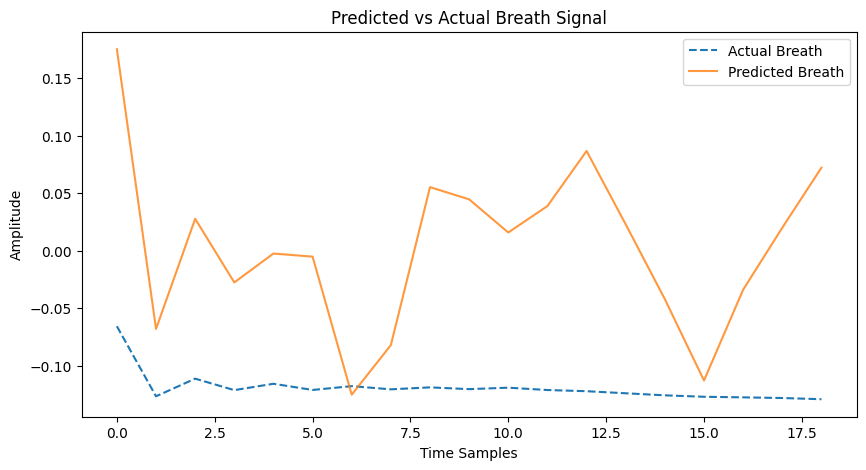

In [ ]:
# Calculate Metrics
correlation = np.corrcoef(breath_data, predicted_breath)[0, 1]
mse = mean_squared_error(breath_data, predicted_breath)
print(f"Correlation: {correlation:.4f}")
print(f"MSE: {mse:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(breath_data, label='Actual Breath', linestyle='dashed')
plt.plot(predicted_breath, label='Predicted Breath', alpha=0.8)
plt.xlabel("Time Samples")
plt.ylabel("Amplitude")
plt.title("Predicted vs Actual Breath Signal")
plt.legend()
plt.show()
